In [32]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Function to extract keypoints from video
def extract_keypoints_from_video(video_path):
    cap = cv2.VideoCapture(video_path)
    keypoints_list = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert the frame to RGB (MediaPipe uses RGB)
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Process the frame to extract keypoints
        results = pose.process(image_rgb)
        
        # Extract keypoints (33 landmarks with x, y, z coordinates)
        if results.pose_landmarks:
            keypoints = []
            for landmark in results.pose_landmarks.landmark:
                # Append (x, y, z) coordinates for each keypoint
                keypoints.extend([landmark.x, landmark.y, landmark.z])
        else:
            keypoints = [0] * 99  # 33 landmarks * 3 coordinates (x, y, z) = 99 features
        
        keypoints_list.append(keypoints)

    cap.release()
    return keypoints_list

# Path to folders
folders = {
    "Squats": "D:\DEPI Material\DEPI_Project\Squats",
    "Push-ups": "D:\DEPI Material\DEPI_Project\Push-ups",
    "Bicep-curls": "D:\DEPI Material\DEPI_Project\Biceps-curl"
}

# List to hold all the extracted data
data = []

# Loop over each folder and extract keypoints
for label, folder in folders.items():
    for video_file in os.listdir(folder):
        if video_file.endswith(".mp4"):  # Adjust if videos are in a different format
            video_path = os.path.join(folder, video_file)
            
            # Extract keypoints
            keypoints_list = extract_keypoints_from_video(video_path)
            
            # Add the label (class name) to each row of extracted keypoints
            for keypoints in keypoints_list:
                data.append([*keypoints, label])  # Append keypoints and the label (Squats, Push-ups, etc.)

# Define column names: (x1, y1, z1, x2, y2, z2, ..., x33, y33, z33, target)
columns = []
for i in range(33):
    columns.extend([f'x{i+1}', f'y{i+1}', f'z{i+1}'])  # Create columns in (x1, y1, z1) format
columns.append('target')  # Add the target column (label)

# Convert the data into a DataFrame
df = pd.DataFrame(data, columns=columns)

# Save the DataFrame to a CSV file
df.to_csv('workout_data.csv', index=False)

print("CSV file created successfully!")


c:\Users\aboen\anaconda3\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


CSV file created successfully!


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the data from the CSV file
df = pd.read_csv(r"Workout_data.csv")

# Separate features and target
X = df.drop('target', axis=1)  # Features (keypoints)
y = df['target']  # Target (workout class)

# Split the data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Normalize the keypoints using StandardScaler (important for some models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Initialize the Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training set
clf.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy * 100:.2f}%")


Test set accuracy: 99.26%


In [7]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate a confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)


Classification Report:
              precision    recall  f1-score   support

 Bicep-curls       1.00      0.97      0.99      2568
     Neutral       0.98      1.00      0.99      3120
    Push-ups       1.00      1.00      1.00      1603
      Squats       1.00      1.00      1.00      4149

    accuracy                           0.99     11440
   macro avg       0.99      0.99      0.99     11440
weighted avg       0.99      0.99      0.99     11440

Confusion Matrix:
[[2496   67    1    4]
 [   1 3119    0    0]
 [   0    5 1598    0]
 [   2    5    0 4142]]


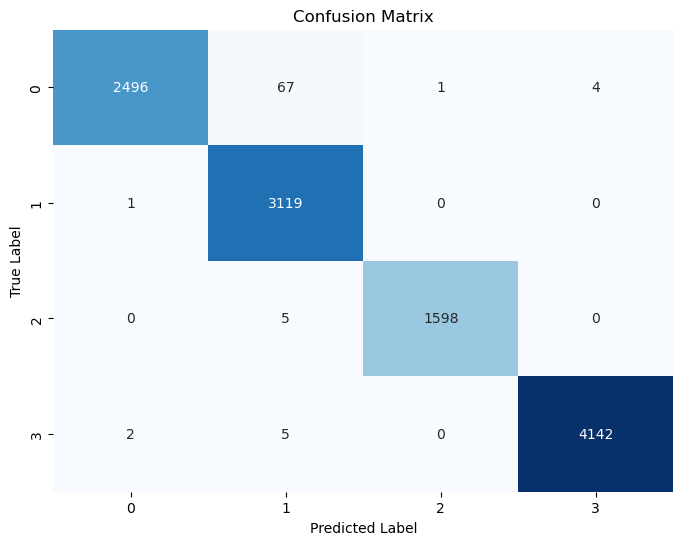

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap to visualize it
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()